# Customer Analysis
Cohort, Retention, Lifetime Value & RFM Analysis using Machine Learning
---

**Analysis:**

Split the data in differents cohorts depending on user's creation date. Identify their retention using a Retention chart and analysis their behaviour using a RFM analysis and Machine Learning. 

The machine learning model attempts to predict what users should have bought but didnt. It does not forecast what they will be doing next but what they should have done in the last month giving their past performance. 

**Useful links:**
- [Step-by-step video guide. Youtube](https://www.youtube.com/watch?v=s-32u6XdY7c)
- [What is RFM analysis. Youtube](https://www.youtube.com/watch?v=guj2gVEEx4s)
- [Lifetime Value Analysis. Medium](https://medium.com/@ugursavci/customer-lifetime-value-prediction-in-python-89e4a50df12e)
- [Improve Random Forest Hyperparameters. Medium](https://towardsdatascience.com/random-forest-hyperparameters-and-how-to-fine-tune-them-17aee785ee0d#:~:text=The%20most%20important%20hyper%2Dparameters,MSE%20or%20MAE%20for%20regression)

**Questions to answer:**
- 1. Which customers had a high purchase probability but didnt do anything in the next 30 days. These could be dormant customers that could be revived with the right marketing campaign. Users that should have bought according to our model but didnt.
- 2. Which customers have recently purchased but are unlikely to buy again. Users with high Recency our model predicted wont buy. A marketing campaign to target these customers could revive them.
- 3. Which customers with high spending had a low probability of purchasing it again. By studing these customers we could see what improvements we should make or if there are new competitors in town.

In [225]:
# Imports and general settings

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, r2_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

pd.set_option('display.max_columns', None)

## Data Wrangling and EDA

In [226]:
# Reading csv file
df = pd.read_csv('../data/cohort_data.csv')

In [227]:
df.head()

,txn_id,txn_date,amount_usd,user_id,user_date
0,t3580,2022-09-30 00:00:00,24.50,u1038,2022-09-10 00:00:00
1,t3581,2022-09-30 00:00:00,272.25,u348,2021-09-15 00:00:00
2,t3582,2022-09-30 00:00:00,5.44,u1491,2022-09-30 00:00:00
3,t3583,2022-09-30 00:00:00,54.45,u17,2022-03-08 00:00:00
4,t3584,2022-09-30 00:00:00,108.90,u465,2022-05-12 00:00:00


In [228]:
df.shape

(109059, 5)

In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109059 entries, 0 to 109058
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   txn_id      109059 non-null  object 
 1   txn_date    109059 non-null  object 
 2   amount_usd  109059 non-null  float64
 3   user_id     109059 non-null  object 
 4   user_date   109059 non-null  object 
dtypes: float64(1), object(4)
memory usage: 4.2+ MB


In [230]:
df['txn_date'] = pd.to_datetime(df['txn_date'], format='%Y-%m-%d %H:%M:%S')
df['user_date'] = pd.to_datetime(df['user_date'], format='%Y-%m-%d %H:%M:%S')
df['txn_date_ym'] = df['txn_date'].apply(lambda x: x.to_period('M'))
df['user_date_ym'] = df['user_date'].apply(lambda x: x.to_period('M'))

In [231]:
df.head()

,txn_id,txn_date,amount_usd,user_id,user_date,txn_date_ym,user_date_ym
0,t3580,2022-09-30,24.50,u1038,2022-09-10,2022-09,2022-09
1,t3581,2022-09-30,272.25,u348,2021-09-15,2022-09,2021-09
2,t3582,2022-09-30,5.44,u1491,2022-09-30,2022-09,2022-09
3,t3583,2022-09-30,54.45,u17,2022-03-08,2022-09,2022-03
4,t3584,2022-09-30,108.90,u465,2022-05-12,2022-09,2022-05


## Initial Exploratory Analysis

In [232]:
df[['user_date_ym', 'user_id']].groupby('user_date_ym').count().sort_index().T

user_date_ym,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09
user_id,10,29,68,270,159,347,293,399,704,261,425,507,856,1474,1290,689,464,1346,1763,3599,3846,4628,7400,13251,35273,12439,7104,3163,1867,1635,1504,1229,767


In [233]:
orders_per_user = df.groupby('user_id')['txn_id'].nunique()
multiple_orders_user = np.sum(orders_per_user > 1) / df.user_id.nunique()
print('More than half of the customers have made 2 or more orders:', f'{round(100*multiple_orders_user, 2)}%')

More than half of the customers have made 2 or more orders: 61.04%


In [234]:
outliers = len(orders_per_user.loc[lambda x: x > 200])
print('There are some outliers (users):', outliers)

There are some outliers (users): 31


Right (Positive) Skewed distribution. Most of the customers performed 10 or less transactions.


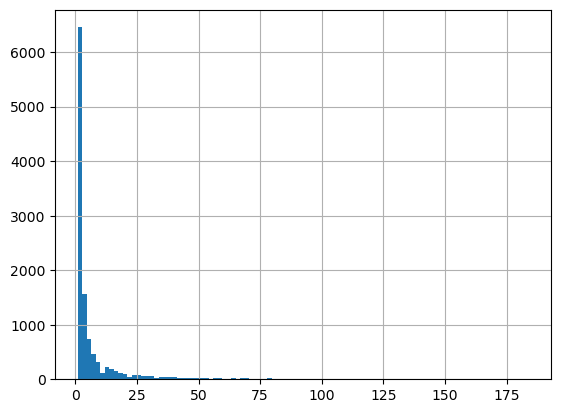

In [235]:
orders_per_user.loc[lambda x: x < 200].hist(bins=100)
print('Right (Positive) Skewed distribution. Most of the customers performed 10 or less transactions.')

In [236]:
# There are outliers worth investigating such as the user u7887 with a total of 915 transactions.
orders_per_user.sort_values(ascending=False).head()

user_id
u7887    915
u5649    786
u794     508
u17      506
u2756    420
Name: txn_id, dtype: int64

### Outliers Clean up

<AxesSubplot:>

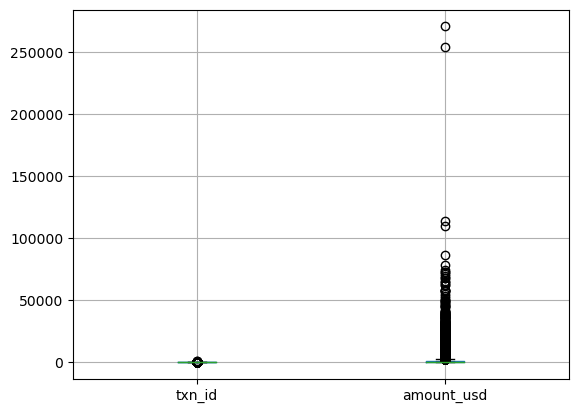

In [237]:
count_sum = df.groupby('user_id')[['txn_id', 'amount_usd']].agg({'txn_id': 'count', 'amount_usd': 'sum'})
count_sum.boxplot()

In [238]:
def find_boundaries(df, feature, q1=0.05, q2=0.95):
    # the boundaries are the quantiles
    lower_boundary = df[feature].quantile(q1) # lower quantile
    upper_boundary = df[feature].quantile(q2) # upper quantile
    return upper_boundary, lower_boundary

In [239]:
def capping_outliers(df, feature):
    upper_boundary, lower_boundary = find_boundaries(df, feature)
    df[feature] = np.where(df[feature] > upper_boundary, upper_boundary, 
                           np.where(df[feature] < lower_boundary, lower_boundary, df[feature]))

In [240]:
count_bounds = list(map(round, find_boundaries(count_sum, 'txn_id')))
count_bounds

[42, 1]

In [241]:
sum_bounds = list(map(round, find_boundaries(count_sum, 'amount_usd')))
sum_bounds

[9627, 5]

In [242]:
# Selecting those users that are within the boundaries
users = set(count_sum[(count_sum['txn_id'] <= count_bounds[0]) & (count_sum['txn_id'] >= count_bounds[1]) & \
         (count_sum['amount_usd'] <= sum_bounds[0]) & (count_sum['amount_usd'] >= sum_bounds[1])].index)

In [243]:
df = df[df['user_id'].isin(users)]

In [244]:
df.shape

(50158, 7)

## Cohort Analysis

In [245]:
# Create a cohort raw table, number of customer per creation date and transaction month.
co = df.groupby(['user_date_ym', 'txn_date_ym'])[['user_id']].agg(n_customers=('user_id', 'nunique')) \
                                                                        .reset_index(drop=False)
co.head()

,user_date_ym,txn_date_ym,n_customers
0,2020-01,2020-03,2
1,2020-01,2020-04,2
2,2020-01,2020-05,2
3,2020-01,2020-06,1
4,2020-01,2021-03,1


In [246]:
# Use period to change the cohort arrangement, every period equals one month here.
co['period'] = co \
.apply(lambda x: (x.txn_date_ym.year - x.user_date_ym.year) * 12 + (x.txn_date_ym.month  - x.user_date_ym.month), axis=1)
co.head()

,user_date_ym,txn_date_ym,n_customers,period
0,2020-01,2020-03,2,2
1,2020-01,2020-04,2,3
2,2020-01,2020-05,2,4
3,2020-01,2020-06,1,5
4,2020-01,2021-03,1,14


In [247]:
# Removing errors and selection last year only.
co_22 = co[(co.user_date_ym >= '2022-01') & (co.period >= 0)].reset_index(drop=True)
co_22.head()

,user_date_ym,txn_date_ym,n_customers,period
0,2022-01,2022-01,911,0
1,2022-01,2022-02,371,1
2,2022-01,2022-03,171,2
3,2022-01,2022-04,116,3
4,2022-01,2022-05,64,4


In [248]:
# Creating Cohort table based on periods or txn_date_ym column. Same data, different sorting.
cohort_pivot_period = co_22.pivot_table(index = 'user_date_ym', columns = 'period', values = 'n_customers')
cohort_pivot_by_txn = co_22.pivot_table(index = 'user_date_ym', columns = 'txn_date_ym', values = 'n_customers')

In [249]:
cohort_pivot_period

period,0,1,2,3,4,5,6,7,8
user_date_ym,,,,,,,,,
2022-01,911.0,371.0,171.0,116.0,64.0,53.0,53.0,45.0,30.0
2022-02,556.0,263.0,174.0,76.0,63.0,60.0,53.0,36.0,NaN
2022-03,541.0,263.0,130.0,86.0,71.0,64.0,54.0,NaN,NaN
2022-04,493.0,230.0,130.0,111.0,100.0,80.0,NaN,NaN,NaN
2022-05,364.0,167.0,123.0,99.0,74.0,NaN,NaN,NaN,NaN
2022-06,323.0,149.0,108.0,95.0,NaN,NaN,NaN,NaN,NaN
2022-07,360.0,183.0,116.0,NaN,NaN,NaN,NaN,NaN,NaN
2022-08,398.0,175.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09,430.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [250]:
cohort_pivot_by_txn

txn_date_ym,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09
user_date_ym,,,,,,,,,
2022-01,911.0,371.0,171.0,116.0,64.0,53.0,53.0,45.0,30.0
2022-02,NaN,556.0,263.0,174.0,76.0,63.0,60.0,53.0,36.0
2022-03,NaN,NaN,541.0,263.0,130.0,86.0,71.0,64.0,54.0
2022-04,NaN,NaN,NaN,493.0,230.0,130.0,111.0,100.0,80.0
2022-05,NaN,NaN,NaN,NaN,364.0,167.0,123.0,99.0,74.0
2022-06,NaN,NaN,NaN,NaN,NaN,323.0,149.0,108.0,95.0
2022-07,NaN,NaN,NaN,NaN,NaN,NaN,360.0,183.0,116.0
2022-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,398.0,175.0
2022-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0


In [251]:
cohort_size = df.groupby('user_date_ym').agg(cohort_size=('user_id', 'nunique'))['2022-01':]
cohort_size.T

user_date_ym,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09
cohort_size,1189,744,741,667,519,455,445,466,430


In [252]:
retention_matrix = cohort_pivot_by_txn.apply(lambda x: x.div(cohort_size.values.flatten()), axis=0)
retention_matrix

txn_date_ym,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09
user_date_ym,,,,,,,,,
2022-01,0.76619,0.312027,0.143818,0.097561,0.053827,0.044575,0.044575,0.037847,0.025231
2022-02,NaN,0.747312,0.353495,0.233871,0.102151,0.084677,0.080645,0.071237,0.048387
2022-03,NaN,NaN,0.730094,0.354926,0.175439,0.116059,0.095816,0.086370,0.072874
2022-04,NaN,NaN,NaN,0.739130,0.344828,0.194903,0.166417,0.149925,0.119940
2022-05,NaN,NaN,NaN,NaN,0.701349,0.321773,0.236994,0.190751,0.142582
2022-06,NaN,NaN,NaN,NaN,NaN,0.709890,0.327473,0.237363,0.208791
2022-07,NaN,NaN,NaN,NaN,NaN,NaN,0.808989,0.411236,0.260674
2022-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.854077,0.375536
2022-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


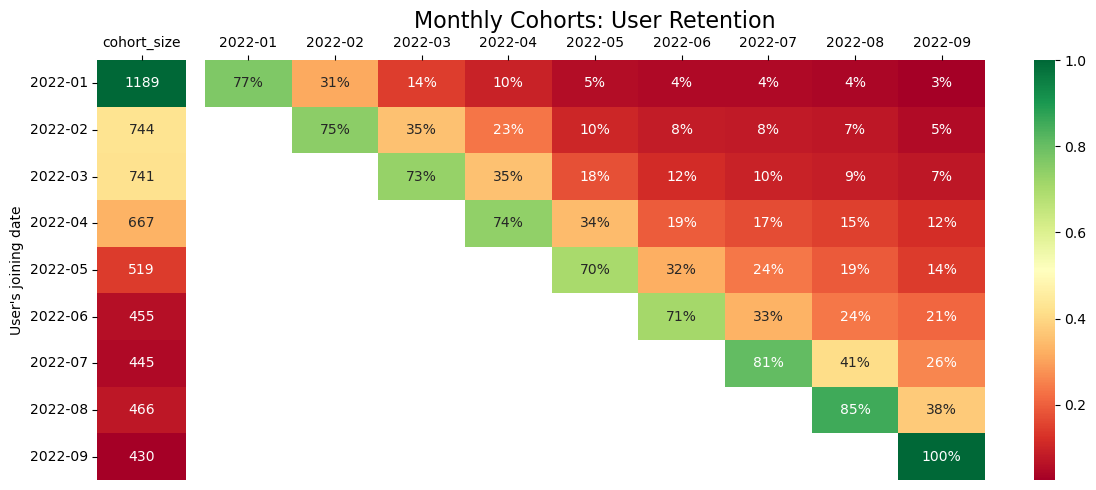

In [253]:
# Plotting
#with sns.axes_style("white"):
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

# retention matrix
sns.heatmap(retention_matrix, mask=retention_matrix.isnull(), annot=True, fmt='.0%', cmap='RdYlGn', ax=ax[1])
ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16) 
ax[1].set(xlabel='', ylabel='')
ax[1].xaxis.set_label_position('top') # Sets x label name at the top
ax[1].xaxis.tick_top() # Set x ticks at the top
ax[1].yaxis.set_ticks_position('none') # removes y tick mark (-)

# cohort size
cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
sns.heatmap(cohort_size_df, annot=True, cbar=False, fmt='g', cmap='RdYlGn', ax=ax[0])
ax[0].set_ylabel("User's joining date")
ax[0].xaxis.tick_top()
fig.tight_layout()

### Conclusions

- 1. The number of users is declining month by month. 
- 2. First month (period) does not add up 100% this is due to the fact that there are users that didnt perform any purchase the month they joined.
- 3. Retention decreases fast in the first 3 months going from ~80% to ~10%.

## RFM Analysis with Machine Learning

We will dive deep into January since it is the month with the highest number of new users (1516)

In [222]:
t = '2022-01'
co = df[df['user_date_ym'] == t][['txn_id', 'user_id', 'txn_date', 'txn_date_ym', 'amount_usd']].reset_index(drop=True)
co.head()

,txn_id,user_id,txn_date,txn_date_ym,amount_usd
0,t3670,u1379,2022-09-30,2022-09,17.97
1,t3672,u1379,2022-09-30,2022-09,17.97
2,t3740,u1537,2022-09-30,2022-09,13.61
3,t3761,u8,2022-09-29,2022-09,27.22
4,t3766,u745,2022-09-29,2022-09,49.00


In [223]:
co_summary = co.groupby('txn_date_ym').agg(txn_count=('txn_id', 'count'), user_count=('user_id', 'nunique'), 
                                           amount_sum=('amount_usd', 'sum'), amount_mean=('amount_usd', 'mean'))
co_summary

,txn_count,user_count,amount_sum,amount_mean
txn_date_ym,,,,
2022-01,5064,911,1381157.45,272.740413
2022-02,2501,371,585853.13,234.247553
2022-03,707,171,80713.61,114.163522
2022-04,483,116,41494.46,85.909855
2022-05,173,64,10576.97,61.138555
2022-06,123,53,13040.29,106.018618
2022-07,135,53,15317.60,113.463704
2022-08,88,45,10830.31,123.071705
2022-09,62,30,6996.15,112.841129


<AxesSubplot:xlabel='txn_date_ym'>

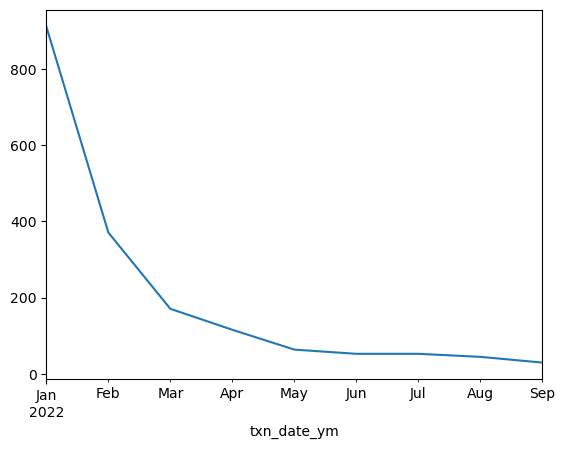

In [224]:
# As expected, the number of active customers drops as time goes by.
co_summary['user_count'].plot()

### Machine Learning

- Which customers had a high purchase probability but didnt do anything in the next 30 days. Compare y_pred and y_true.
- Which customers have recently purchased but are unlikely to buy again. Compare Recency values with y_pred.

We will take first three month of the year (January, February and March) for training and the fourth month (April) as our test data. Notice this is a supervised model. We are not predicting what the user would do next, we are attempting to determine what the customers should have done during the fourth month giving their behaviour the first three months.

The model will be a Random Forest Classifier.

In [159]:
# Setting X and y split date
co_final = co[(co['txn_date_ym'] >= '2022-01') & (co['txn_date_ym'] <= '2022-04')]
co_final.head()

,txn_id,user_id,txn_date,txn_date_ym,amount_usd
581,t20507,u4544,2022-04-30,2022-04,408.37
582,t20577,u1418,2022-04-30,2022-04,12.25
583,t20621,u3887,2022-04-30,2022-04,19.06
584,t20632,u4270,2022-04-30,2022-04,49.55
585,t20633,u4270,2022-04-30,2022-04,49.55


In [160]:
cutoff = co_final.txn_date.max() - pd.to_timedelta(30, unit='d')
cutoff

Timestamp('2022-03-31 00:00:00')

In [161]:
# Splitting into X and y. first split, raw.
x_raw = co_final[co_final['txn_date'] < cutoff]
y_raw = co_final[co_final['txn_date'] >= cutoff]
print('X dataset split %:', round(len(x_raw)/len(co_final), 2), '\ny dataset split %:', round(len(y_raw)/len(co_final), 2))

X dataset split %: 0.94 
y dataset split %: 0.06


#### Creating y true

In [162]:
# Users that were active the fourth month.
def create_ytrue(df):
    y = df.groupby('user_id')[['amount_usd']].sum().set_axis(['true_amnt_spent'], axis=1)
    y['is_active'] = 1
    return y

y = create_ytrue(y_raw)
y.head()

,true_amnt_spent,is_active
user_id,,
u1140,27.22,1
u1418,168.79,1
u1753,5.44,1
u1805,1007.32,1
u2170,114.34,1


#### Feature Engineering

**Recency**

In [163]:
def recency(df):
    
    def last_buy_days(x, compare_to):
        val = compare_to - x.max()[1]
        return val.days
    
    oldest_date = df.txn_date.max()
    
    grp = df.groupby('user_id')[['user_id', 'txn_date']].apply(lambda x: last_buy_days(x, oldest_date))
    recency = grp.to_frame().set_axis(['recency'], axis=1)
    return recency

recency_df = recency(x_raw)
recency_df.head()

,recency
user_id,
u1379,37
u1418,10
u1425,66
u1469,24
u1537,40


**Frequency**

In [164]:
def frequency(df):
    return df.groupby('user_id')['txn_date'].count().to_frame().set_axis(['frequency'], axis=1)
                                                                         
frequency_df = frequency(x_raw)
frequency_df.head()

,frequency
user_id,
u1379,5
u1418,11
u1425,2
u1469,2
u1537,2


**Monetary Value**

In [165]:
def monetary_value(df):
    return df.groupby('user_id')[['amount_usd']].agg(['sum', 'mean']).set_axis(['price_sum', 'price_mean'], axis=1)

mv_df = monetary_value(x_raw)
mv_df.head()

,price_sum,price_mean
user_id,,
u1379,727.18,145.436000
u1418,169.86,15.441818
u1425,83.31,41.655000
u1469,13.61,6.805000
u1537,32.66,16.330000


**Average Time between Orders**

In [166]:
def avg_time_orders(df):
    df = df.groupby('user_id').agg(first_order=('txn_date', 'min'), 
                                   last_order=('txn_date', 'max'), 
                                   n_orders=('txn_id', 'count'))
    
    df['days_diff'] = (df['last_order'] - df['first_order']).dt.days
    df['avg_time_buy'] = (df['days_diff'] / df['n_orders']).apply(lambda x: math.ceil(x))
    return df[['avg_time_buy']]

avg_time_buy_df = avg_time_orders(x_raw)
avg_time_buy_df.head()

,avg_time_buy
user_id,
u1379,5
u1418,6
u1425,7
u1469,18
u1537,13


In [167]:
# Merging X datasets

def df_merger(dfs):
    return pd.concat(dfs, axis=1)

x = df_merger([recency_df, frequency_df, mv_df, avg_time_buy_df])
x.head()

,recency,frequency,price_sum,price_mean,avg_time_buy
user_id,,,,,
u1379,37,5,727.18,145.436000,5
u1418,10,11,169.86,15.441818,6
u1425,66,2,83.31,41.655000,7
u1469,24,2,13.61,6.805000,18
u1537,40,2,32.66,16.330000,13


#### Joining X and y into one single dataset

In [168]:
xy = x.join(y, how='left').fillna(0)
xy.head()

,recency,frequency,price_sum,price_mean,avg_time_buy,true_amnt_spent,is_active
user_id,,,,,,,
u1379,37,5,727.18,145.436000,5,0.00,0.0
u1418,10,11,169.86,15.441818,6,168.79,1.0
u1425,66,2,83.31,41.655000,7,0.00,0.0
u1469,24,2,13.61,6.805000,18,0.00,0.0
u1537,40,2,32.66,16.330000,13,0.00,0.0


In [169]:
x = xy[['recency', 'frequency', 'price_sum', 'price_mean', 'avg_time_buy']]
x.head()

,recency,frequency,price_sum,price_mean,avg_time_buy
user_id,,,,,
u1379,37,5,727.18,145.436000,5
u1418,10,11,169.86,15.441818,6
u1425,66,2,83.31,41.655000,7
u1469,24,2,13.61,6.805000,18
u1537,40,2,32.66,16.330000,13


In [170]:
y_reg = xy['true_amnt_spent']
y_cls = xy['is_active']
y_cls.head()

user_id
u1379    0.0
u1418    1.0
u1425    0.0
u1469    0.0
u1537    0.0
Name: is_active, dtype: float64

#### Train Test Split

In [171]:
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x, y_reg, test_size=0.2, random_state=42)
x_train_cls, x_test_cls, y_train_cls, y_test_cls = train_test_split(x, y_cls, test_size=0.2, random_state=42)

print(f'Train dataset size: {len(x_train_cls)}\nTest dataset size: {len(x_test_cls)}')

Train dataset size: 892
Test dataset size: 224


#### Training model and testing

**Train Data test**

In [172]:
model = RandomForestClassifier(random_state=42)

model.fit(x_train_cls, y_train_cls)
y_pred = pd.DataFrame(model.predict(x_train_cls), columns=['y_pred'])

y_true = pd.DataFrame(y_train_cls.values, columns=['y_true'])

accuracy_score(y_true['y_true'], y_pred['y_pred'])

0.9955156950672646

**Test Data test**

In [173]:
model = RandomForestClassifier(random_state=42)

model.fit(x_train_cls, y_train_cls)
y_pred = pd.DataFrame(model.predict(x_test_cls), columns=['y_pred'])

y_true = pd.DataFrame(y_test_cls.values, columns=['y_true'])

accuracy_score(y_true['y_true'], y_pred['y_pred'])

0.9017857142857143

#### Final Model

Since our accuracy score has been met (higher than 85%), we proceed to train the model using an X that takes all users and transactions from the 3 first months and y with transactions and users from the 4th month. Once trained, we will predict and X that takes all users from the first 4 months.

We will compare this prediction to what the users really did in the fourth month.

In [174]:
# Setting model hyperparameters and fitting.
model = RandomForestClassifier(random_state=42)

model.fit(x, y_cls)

RandomForestClassifier(random_state=42)

In [175]:
# Predicting 4th month behaviour.

a = recency(co_final)
b = frequency(co_final)
c = monetary_value(co_final)
d = avg_time_orders(co_final)

to_pred = df_merger([a,b,c,d])
pred = model.predict(to_pred)

forecast = pd.DataFrame(zip(to_pred.index, pred), columns=['user_id', 'y_pred'])

y_pred_true = pd.merge(forecast, y_cls.to_frame().reset_index(drop=False), on='user_id', how='outer')

#NaN means that their first order was in the fourth month
y_pred_true.fillna(1, inplace=True)

In [176]:
# Checking prediction accuracy, should be similar to what we previously got.
y_pred_true['reality_check'] = y_pred_true.apply(lambda x: True if x['y_pred'] == x['is_active'] else False, axis=1)
y_pred_true['reality_check'].sum() / len(y_pred_true)

0.9187772925764193

In [177]:
final = pd.merge(to_pred.reset_index(drop=False), y_pred_true, on='user_id', how='left')

In [178]:
final.head()

,user_id,recency,frequency,price_sum,price_mean,avg_time_buy,y_pred,is_active,reality_check
0,u1140,3,1,27.22,27.220,0,0.0,1.0,False
1,u1379,68,5,727.18,145.436,5,0.0,0.0,True
2,u1418,0,13,338.65,26.050,8,1.0,1.0,True
3,u1425,97,2,83.31,41.655,7,0.0,0.0,True
4,u1469,55,2,13.61,6.805,18,0.0,0.0,True


### Feature Importance

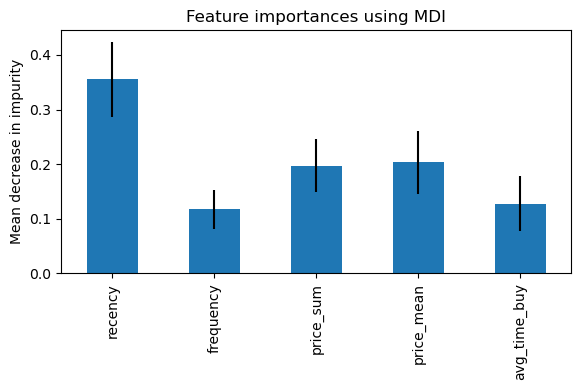

In [179]:
importances = model.feature_importances_

std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=x.columns)

fig, ax = plt.subplots(figsize=(6,4))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Model Tuning

Hyperparameters to tune are:
- `n_estimators`: Number of trees in the forest. Ideally you should be choosing a large number, the more trees the better it fits the data, however, it comes with the cost of increasing computational time.
- `criterion`: How the forest should be generated. How to split the data. When it comes to Classification problems we could choose between Gini or Entropy and for Regression problems we have MAE or MSE. There is no rule of thumb when choosing one over the other, just try them all out and stick with the one that works best. Gini is faster since it does not compute any logarithm.
- `max_depth`: How deep individual trees are. The deeper the better, however, you might still run into overfitting your model. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

## Business Questions

1. Which customers had a high purchase probability but didnt do anything in the next 30 days.

In [180]:
final[(final['is_active'] == 0) & (final['y_pred'] == 1)].sort_values('y_pred', ascending=False)

,user_id,recency,frequency,price_sum,price_mean,avg_time_buy,y_pred,is_active,reality_check
28,u2858,51,1,5.44,5.440000,0,1.0,0.0,False
156,u5591,41,9,404.26,44.917778,9,1.0,0.0,False


2. Which customers have recently purchased but are unlikely to buy again

In [181]:
final[(final['recency'] <= 5) & (final['y_pred'] == 0)].sort_values('y_pred', ascending=False)

,user_id,recency,frequency,price_sum,price_mean,avg_time_buy,y_pred,is_active,reality_check
0,u1140,3,1,27.22,27.220000,0,0.0,1.0,False
15,u242,4,13,514.26,39.558462,9,0.0,1.0,False
27,u2853,5,3,27.22,9.073333,0,0.0,1.0,False
66,u4471,1,15,5015.90,334.393333,8,0.0,1.0,False
75,u4646,3,21,1841.20,87.676190,5,0.0,1.0,False
76,u4668,3,1,5.44,5.440000,0,0.0,1.0,False
79,u4691,4,16,4024.08,251.505000,7,0.0,1.0,False
81,u4703,5,3,25.59,8.530000,18,0.0,1.0,False
82,u4716,5,10,3446.40,344.640000,9,0.0,1.0,False
97,u50,5,1,5.44,5.440000,0,0.0,1.0,False
